In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
dfs = pd.read_csv("full_df.csv")
#去掉年龄太大或者太小的
dfs = dfs[dfs['Patient Age'].map(lambda x:10<=x<=80)]

In [24]:
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0
dfs["left_glaucoma"] = dfs["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
dfs["right_glaucoma"] = dfs["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
left_glaucoma = dfs.loc[(dfs.G ==1) & (dfs.left_glaucoma == 1)]["Left-Fundus"].values
right_glaucoma = dfs.loc[(dfs.G ==1) & (dfs.right_glaucoma == 1)]["Right-Fundus"].values
def has_retinopathy(text):
    if "retinopathy" in text:
        return 1
    else:
        return 0
dfs["left_retinopathy"] = dfs["Left-Diagnostic Keywords"].apply(lambda x: has_retinopathy(x))
dfs["right_retinopathy"] = dfs["Right-Diagnostic Keywords"].apply(lambda x: has_retinopathy(x))
left_retinopathy = dfs.loc[(dfs.D ==1) & (dfs.left_retinopathy == 1)]["Left-Fundus"].sample(300,random_state=42).values
right_retinopathy = dfs.loc[(dfs.D ==1) & (dfs.right_retinopathy == 1)]["Right-Fundus"].sample(300,random_state=42).values
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0
dfs["left_cataract"] = dfs["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
dfs["right_cataract"] = dfs["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
left_cataract = dfs.loc[(dfs.C ==1) & (dfs.left_cataract == 1)]["Left-Fundus"].values
right_cataract = dfs.loc[(dfs.C ==1) & (dfs.right_cataract == 1)]["Right-Fundus"].values   

glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=-1)
retinopathy = np.concatenate((left_retinopathy,right_retinopathy),axis=-1)
cataract = np.concatenate((left_cataract,right_cataract),axis=-1)

In [25]:
# 创建标签数组
labels = np.concatenate((np.zeros(len(glaucoma)), np.ones(len(retinopathy)), np.full(len(cataract), 2)))
labels = labels.astype(int)
# 创建数据数组
data = np.concatenate((glaucoma, retinopathy, cataract))

# 创建DataFrame
df = pd.DataFrame({'Data': data, 'Label': labels})

In [26]:
res = df.sample(n = len(df))
train = res.iloc[:int(len(res)*0.7)]
val = res.iloc[int(len(res)*0.7):int(len(res)*0.9)]
test = res.iloc[int(len(res)*0.9):]

In [27]:
value_counts1 = train["Label"].value_counts()
print(value_counts1)

1    435
0    415
2    349
Name: Label, dtype: int64


In [28]:
value_counts2 = val["Label"].value_counts()
print(value_counts2)

0    119
1    114
2    109
Name: Label, dtype: int64


In [29]:
value_counts3 = test["Label"].value_counts()
print(value_counts3)

2    64
0    57
1    51
Name: Label, dtype: int64


In [30]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

dataset_dir = "preprocessed_images/"
image_size = 224

def create_dataset(df):
    dataset = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        image_path = os.path.join(dataset_dir, row[0])
        try:
            image = load_img(image_path, target_size=(image_size, image_size))
            image_array = img_to_array(image)
            label = np.array(row[1])
            dataset.append([image_array, label])
        except:
            continue
    
    np.random.shuffle(dataset)
    return dataset


In [31]:
train_data = create_dataset(train)

100%|██████████| 1199/1199 [00:05<00:00, 204.68it/s]


In [32]:
test_data = create_dataset(test)

100%|██████████| 172/172 [00:00<00:00, 246.60it/s]


In [33]:
val_data = create_dataset(val)

100%|██████████| 342/342 [00:01<00:00, 255.59it/s]


In [34]:
x_train = np.array([i[0] for i in train_data]).reshape(-1,image_size,image_size,3)
y_train = np.array([i[1] for i in train_data])

In [35]:
x_test = np.array([i[0] for i in test_data]).reshape(-1,image_size,image_size,3)
y_test = np.array([i[1] for i in test_data])

In [36]:
x_val = np.array([i[0] for i in val_data]).reshape(-1,image_size,image_size,3)
y_val = np.array([i[1] for i in val_data])

In [37]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 对标签数据进行独热编码
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [39]:
train_generator = datagen.flow(x_train, y_train_encoded, batch_size=32)

In [40]:
x_test = preprocess_input(x_test)

In [41]:
print("训练集大小:", x_train.shape[0])
print("测试集大小:", x_test.shape[0])

训练集大小: 1188
测试集大小: 172


In [42]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

2023-09-23 04:47:03.835179: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-09-23 04:47:03.878356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:52:00.0 name: NVIDIA RTX A4000 computeCapability: 8.6
coreClock: 1.56GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2023-09-23 04:47:03.878534: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-23 04:47:03.878766: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcublas.so.10'; dlerror: libcublas.so.10: cannot open shared object file: No such file or direct

In [43]:
for layer in vgg.layers:
    layer.trainable = False

In [44]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(3, activation="softmax")) 

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 26,447,939
Trainable params: 6,423,555
Non-trainable params: 20,024,384
_________________________________________________________________


In [46]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg19.h5", monitor="val_acc", verbose=1, save_best_only=True,
                             save_weights_only=False, period=1)
earlystop = EarlyStopping(monitor="val_acc", patience=5, verbose=1)

In [48]:
# 使用独热编码后的标签进行模型训练
batch_size = 32
history = model.fit_generator(train_generator, steps_per_epoch=len(x_train) // batch_size,
                              epochs=16, validation_data=(x_val, y_val_encoded),
                              verbose=1, callbacks=[checkpoint, earlystop])


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/16
37/37 [==============================] - 216s 6s/step - loss: 11.5042 - accuracy: 0.6194 - val_loss: 4.0039 - val_accuracy: 0.5533
Epoch 2/16
37/37 [==============================] - 214s 6s/step - loss: 1.7781 - accuracy: 0.7578 - val_loss: 2.0478 - val_accuracy: 0.6775
Epoch 3/16
37/37 [==============================] - 212s 6s/step - loss: 1.1261 - accuracy: 0.7647 - val_loss: 0.7274 - val_accuracy: 0.7574
Epoch 4/16
37/37 [==============================] - 213s 6s/step - loss: 0.8360 - accuracy: 0.7829 - val_loss: 0.7301 - val_accuracy: 0.7485
Epoch 5/16
37/37 [==============================] - 213s 6s/step - loss: 0.6789 - accuracy: 0.7967 - val_loss: 0.7220 - val_accuracy: 0.7456
Epoch 6/16
37/37 [==============================] - 212s 6s/step - loss: 0.7225 - accuracy: 0.7958 - val_loss: 0.8963 - val_accuracy: 0.7870
Epoch 7/16
37/37 [==============================] - 214s 6s/step - loss: 0.58

In [49]:
loss1, accuracy1 = model.evaluate(x_train, y_train_encoded)
print("Loss:", loss1)
print("Accuracy:", accuracy1)

38/38 [==============================] - 155s 4s/step - loss: 0.6993 - accuracy: 0.7247
Loss: 0.6993048191070557
Accuracy: 0.7247474789619446


In [50]:
loss2, accuracy2 = model.evaluate(x_test, y_test_encoded)
print("Loss:", loss2)
print("Accuracy:", accuracy2)


6/6 [==============================] - 19s 3s/step - loss: 0.4657 - accuracy: 0.8314
Loss: 0.46573302149772644
Accuracy: 0.8313953280448914


In [51]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict_classes(x_val)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [52]:
accuracy_score(y_val,y_pred)

0.7130177514792899

In [53]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.28      0.44       118
           1       0.57      0.98      0.72       112
           2       0.88      0.91      0.89       108

    accuracy                           0.71       338
   macro avg       0.82      0.72      0.68       338
weighted avg       0.82      0.71      0.68       338



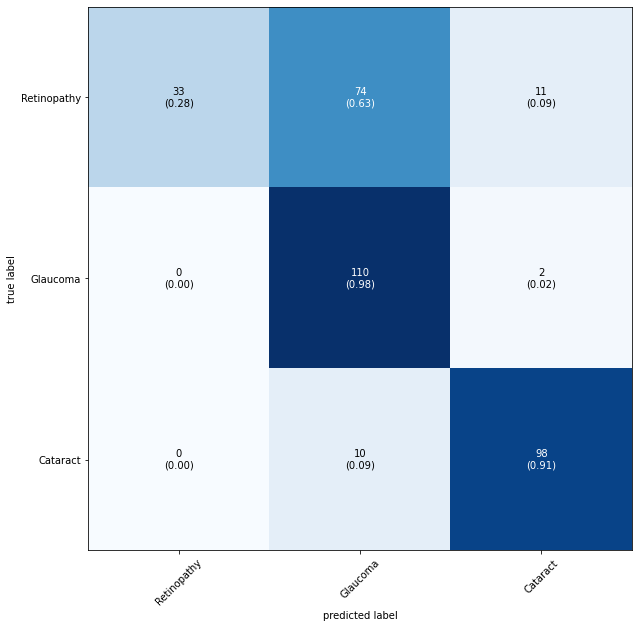

In [54]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_val,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(10,10),class_names = ["Retinopathy","Glaucoma","Cataract"],
                      show_normed = True);

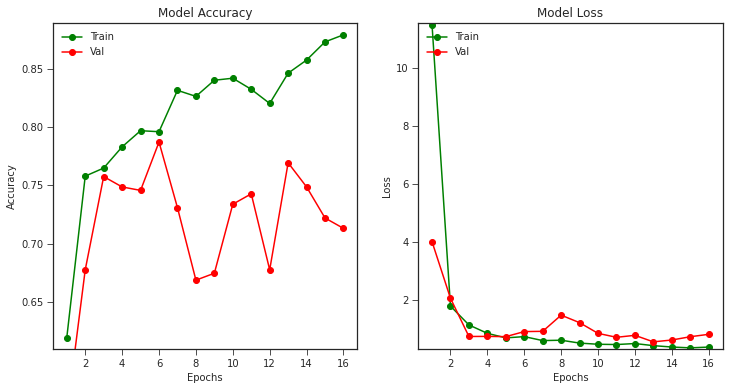

In [55]:
plt.style.use("seaborn-ticks")
fig = plt.figure(figsize=(12,6))
epochs = range(1,17)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([min(history.history["accuracy"])-0.01,max(history.history["accuracy"])+0.01])
plt.legend(["Train","Val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([min(history.history["loss"])-0.05,max(history.history["loss"])+0.05])
plt.legend(["Train","Val"],loc = "upper left")
plt.show()

In [33]:
#plt.style.use("seaborn-ticks")
#plt.figure(figsize=(12,7))
#for i in range(10):
    #sample = random.choice(range(len(x_test)))
    #image = x_test[sample]
    #category = y_test[sample]
    #pred_category = y_pred[sample]
    
    #if category== 0:
        #label = "Retinopathy"
    #else:
        #label = "Glaucoma"
        
    #if pred_category== 0:
        #pred_label = "Retinopathy"
    #else:
        #pred_label = "Glaucoma"
        
    #plt.subplot(2,5,i+1)
    #plt.imshow(image)
    #plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
#plt.tight_layout() 